# API- FROST

### Henter og lagrer værdata fra FrostAPI for Trondheim

In [53]:
import json #for å håndtere json data
import requests #http forespørsler
from datetime import datetime, timedelta 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os #tillgang til filsystem og data 
from dotenv import load_dotenv #laste inn env filer
import sys
sys.path.insert(0,'../../src')
import seaborn as sns #visulisering
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score 
from Api_Frost import hent_frost_data, frost_json_til_dataframe, lagre_til_csv
from plot_funksjon import plott_smart_scatter_2D, plott_smart_scatter_3D
from statistiske_maal import beregne_statistiske_verdier

In [17]:
import json #for å håndtere json data
import requests #http forespørsler
from datetime import datetime, timedelta 
import pandas as pd
import os #tillgang til filsystem og data 
from dotenv import load_dotenv #laste inn env filer
import sys
sys.path.insert(0,'../../src')
from Api_Frost import hent_frost_data, frost_json_til_dataframe, lagre_til_csv
from plot_funksjon import plott_smart_scatter_2D, plott_smart_scatter_3D



load_dotenv() #laster miljødata frå env.fil
client_id = os.getenv('API_KEY3') #Gjør dette med enn .env fil, beskytter KEY
print(client_id)

endpoint = os.getenv('DATABASE_URL3')#henter URL


parameters = {
    "sources" : "SN68860", #målepunkt Trondheim
    "elements" : "mean(air_temperature P1D), mean(air_pressure_at_sea_level P1D), sum(precipitation_amount P1D), mean(wind_speed P1D)",   
    #henter daglig gjennomsnitt av temeraturen, vind, trykket og nedbøret  
    "referencetime" : "2020-03-10/2025-03-19", #tidsperioden
}
#Henter data
json_data = hent_frost_data(endpoint, parameters, client_id)

#Konverterer til dataframe
df = frost_json_til_dataframe(json_data)

#Lagre til CSV
lagre_til_csv(df, "trondheim_vaerdata_full.csv")

#ekstra sjekk
print(df.head())
#datatypen til femte verdien i kolonna med gjennomsnitt
print(type(df["mean(air_temperature P1D)"][4]))
  

a5e627de-9361-4e32-a3c8-953adfcbaa85
Data hentet fra Frost API
data lagret i trondheim_vaerdata_full.csv
                  Tidspunkt  mean(air_temperature P1D)  \
0  2020-03-10T00:00:00.000Z                        3.6   
1  2020-03-11T00:00:00.000Z                        4.5   
2  2020-03-12T00:00:00.000Z                        3.9   
3  2020-03-13T00:00:00.000Z                        0.0   
4  2020-03-14T00:00:00.000Z                       -3.8   

   mean(air_pressure_at_sea_level P1D)  sum(precipitation_amount P1D)  \
0                                988.7                            0.4   
1                                980.6                            0.1   
2                                980.5                            0.1   
3                               1005.4                            6.7   
4                               1011.1                            4.5   

   mean(wind_speed P1D)  
0                   3.0  
1                   3.0  
2                   2.0  
3  

### Lagrer værdata som JSON-fil 

In [40]:
#Lagrer til en JSON-fil
with open("miljodata.json", "w", encoding = "utf-8") as f: 
        #åpner og oppretter en fil for skriving, med gitt navn. Hvis filen allerede finnes, vil den bli overskrevet. 
        #w for write, hvis fil finnest fra før vil den bli overskrevet
        #encoding søreger for at bokstaver som Æ, Ø, Å blir lagra rett
        json.dump(vaerdata, f, indent = 4, ensure_ascii=False )     #Tar et python-objekt og skriver det til en fil i JSON-format. Indent= 4 gir mellomrom for hvert nivå. Spesialtegn blir skrevet ut riktig med ascii

print("Data lagret som miljodata.json") 
#bekreftelse på data er lagra



Data lagret som miljodata.json


### Leser og viser innholdet i JSON-fil

In [39]:
#sjekker hva slags data som er lagret

with open("miljodata.json", "r", encoding = "utf-8") as f:  #åpner filen for lesing, r = read,  encoding sikrer at alle tegn håndteres korrekt
    data = json.load(f) #leser  JSON-data fra filen f og konverterer den til et python-objekt som lagres i variabelen data

print(json.dumps(data, indent=4)) #skriver ut innholdet i filen på en lesbar måte, indent = 4, gir fire mellomrom, lesbart

FileNotFoundError: [Errno 2] No such file or directory: 'miljodata.json'

OPPGAVE 3

### Håndterer manglende verdier i værdatasettet

In [21]:
import pandas as pd 


#identifisere og håndtere databehandling

#identifisere verdier som mangler 
#sjekker hvor mange verdier som mangler i hver kolonne
df = pd.read_csv("trondheim_vaerdata_full.csv")
print(df.isnull().sum())

#fylle inn manglende verdier basert på type data
#numeriske verdier, mean() og median() for å fylle ut hullene


df.fillna({
    "mean(air_temperature P1D)": df["mean(air_temperature P1D)"].median(), 
    "mean(air_pressure_at_sea_level P1D)": df["mean(air_pressure_at_sea_level P1D)"].median(), 
    "sum(precipitation_amount P1D)": df["sum(precipitation_amount P1D)"].fillna(0), #null nedbor
    "mean(wind_speed P1D)": df["mean(wind_speed P1D)"]. fillna(df["mean(wind_speed P1D)"].mean())
}, inplace =True)


#interpolerer for å finne ut manglende verdier
df.interpolate(method = 'linear', inplace= True)


Tidspunkt                              0
mean(air_temperature P1D)              0
mean(air_pressure_at_sea_level P1D)    0
sum(precipitation_amount P1D)          0
mean(wind_speed P1D)                   0
dtype: int64


C:\Users\eriks\AppData\Local\Temp\ipykernel_25912\126067788.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method = 'linear', inplace= True)


### Kategoriserer værdata med list comprehensions

In [41]:
#Bruker list comprehensions for effektiv datamanipilering

#kategorisering av temperatur
df["TemperaurKategori"] = ["Kaldt" if temp < 10
                            else "Mildt" if temp < 20 
                            else "Varmt" for temp in df["mean(air_temperature P1D)"]]

#kategorisering av vind
df["VindKategori"] = ["Vindstille" if vind < 2
                      else "Lett bris" if vind < 10
                      else "Sterk vind" if vind < 20
                      else "storm"for vind in df["mean(wind_speed P1D)"]]


#Kategorisering av trykk
df["TrykkKategori"] = ["Høytrykk" if trykk > 1013
                       else "Lavtrykk" for trykk in df["mean(air_pressure_at_sea_level P1D)"]]

#Kategorisering av nedbor
df["NedborKategori"] = ["Tørt" if nedbor == 0
                        else "Lett regn" if nedbor < 5
                        else "Mye regn " if nedbor < 20
                        else "Ekstrem vær" for nedbor in df["sum(precipitation_amount P1D)"]]

df.head()  #skriver ut de fem øverste



,Tidspunkt,mean(air_temperature P1D),mean(air_pressure_at_sea_level P1D),sum(precipitation_amount P1D),mean(wind_speed P1D),TemperaurKategori,VindKategori,TrykkKategori,NedborKategori,TempDiff,UnormalHoppTemp,PressureDiff,UnormalHoppPressure,Wind_speedDiff,UnormalHoppWind,NedborDiff,UnormalHoppNedbor
0,2020-03-10 00:00:00+00:00,3.6,988.7,0.4,3.0,Kaldt,Lett bris,Lavtrykk,Lett regn,NaN,Nei,NaN,Nei,NaN,Nei,NaN,Nei
1,2020-03-11 00:00:00+00:00,4.5,980.6,0.1,3.0,Kaldt,Lett bris,Lavtrykk,Lett regn,0.9,Nei,-8.1,Nei,0.0,Nei,-0.3,Nei
2,2020-03-12 00:00:00+00:00,3.9,980.5,0.1,2.0,Kaldt,Lett bris,Lavtrykk,Lett regn,-0.6,Nei,-0.1,Nei,-1.0,Nei,0.0,Nei
3,2020-03-13 00:00:00+00:00,0.0,1005.4,6.7,3.1,Kaldt,Lett bris,Lavtrykk,Mye regn,-3.9,Nei,24.9,Nei,1.1,Nei,6.6,Nei
4,2020-03-14 00:00:00+00:00,-3.8,1011.1,4.5,3.9,Kaldt,Lett bris,Lavtrykk,Lett regn,-3.8,Nei,5.7,Nei,0.8,Nei,-2.2,Nei


### Filtrerer "fine dager" med SQL-spørring i Pandas

In [42]:
#Manipulerer dataene effektivt med pandas sql

from pandasql import sqldf
 #legger inn krav for tidspunkt der tempratur, nedbør og vind er opptimal, fint vær
query = """ 
SELECT Tidspunkt, "mean(air_temperature P1D)", "sum(precipitation_amount P1D)", "mean(wind_speed P1D)"
FROM df 
WHERE "mean(air_temperature P1D)" > 20 AND "sum(precipitation_amount P1D)"==0 AND "mean(wind_speed P1D)" < 5
ORDER BY "mean(air_temperature P1D)", "sum(precipitation_amount P1D)",  "mean(wind_speed P1D)"DESC
"""

df_warm_days = sqldf(query, locals())  # Finner den varmeste dagen
print(df_warm_days)  


                     Tidspunkt  mean(air_temperature P1D)  \
0   2024-07-21 00:00:00.000000                       20.2   
1   2020-06-25 00:00:00.000000                       20.5   
2   2023-06-21 00:00:00.000000                       20.6   
3   2023-08-20 00:00:00.000000                       20.8   
4   2020-06-17 00:00:00.000000                       21.0   
5   2024-05-24 00:00:00.000000                       21.5   
6   2024-05-23 00:00:00.000000                       21.6   
7   2024-05-26 00:00:00.000000                       21.6   
8   2020-06-18 00:00:00.000000                       21.6   
9   2023-06-20 00:00:00.000000                       21.6   
10  2022-06-26 00:00:00.000000                       21.9   
11  2023-06-19 00:00:00.000000                       22.0   
12  2024-08-07 00:00:00.000000                       22.2   
13  2022-07-01 00:00:00.000000                       22.3   
14  2020-06-27 00:00:00.000000                       22.5   
15  2022-06-27 00:00:00.

### Visualiserer de fineste dagene med scatterplot

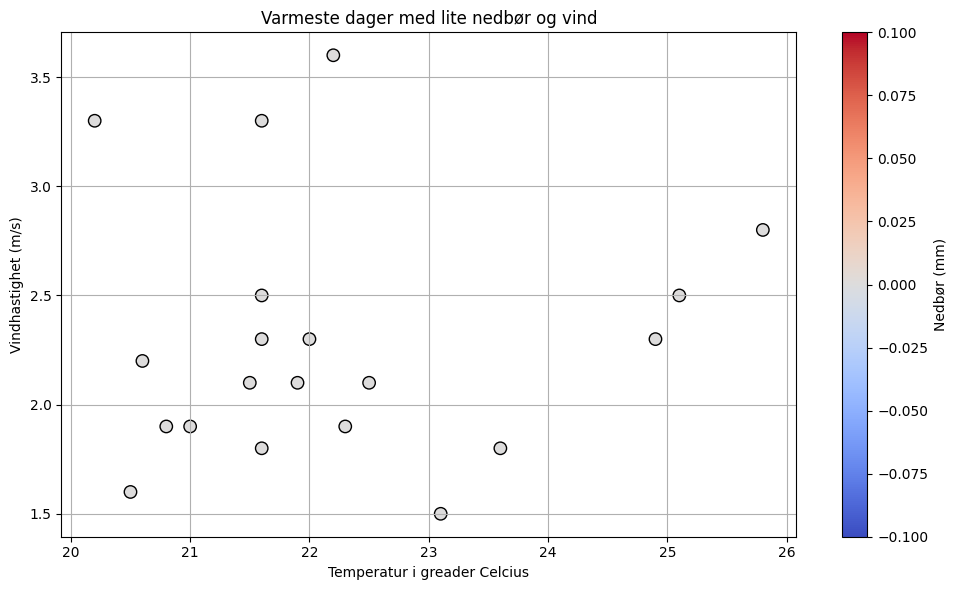

In [43]:
plott_smart_scatter_2D(
    df = df_warm_days, x_col = "mean(air_temperature P1D)",
    y_col = "mean(wind_speed P1D)",
    color_col = "sum(precipitation_amount P1D)",
    x_label= "Temperatur i greader Celcius", 
    y_label = "Vindhastighet (m/s)",
    title = "Varmeste dager med lite nedbør og vind",
    colorbar_label = "Nedbør (mm)"
)


### 3D- visualisering av fine værdager

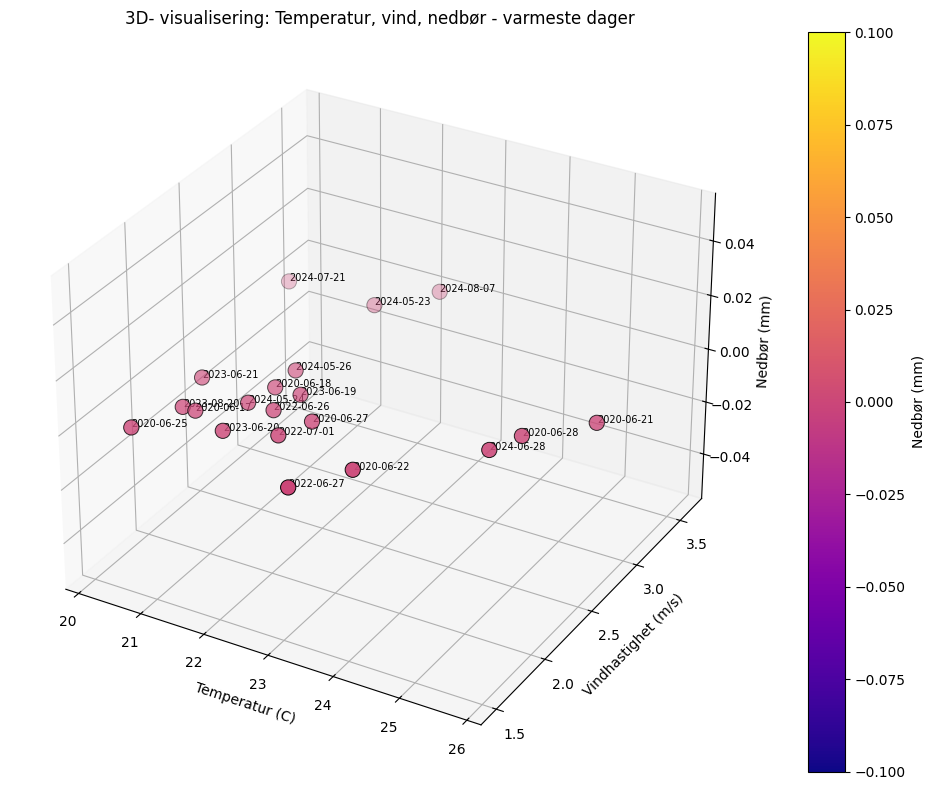

In [45]:
plott_smart_scatter_3D(
    df = df_warm_days,
    x_col = "mean(air_temperature P1D)",
    y_col = "mean(wind_speed P1D)",
    z_col = "sum(precipitation_amount P1D)",
    dato_col = "Tidspunkt",
    x_label = "Temperatur (C)",
    y_label = "Vindhastighet (m/s)",
    z_label = "Nedbør (mm)", 
    title = "3D- visualisering: Temperatur, vind, nedbør - varmeste dager")
 


### Håndtering av uregelmessigheter og feilmålinger i værdata

In [26]:
#HÅNDTERING AV UREGELMESSIGHETER
#værdata som kan være feilmålinger, som ekstreme temperaturer osv, plutselig hopp
#bort med usansynlige temperaturer
df = df[(df["mean(air_temperature P1D)"] > -50) & (df["mean(air_temperature P1D)"] < 50)]
#fjerner negative verdier for nedbør og ekstreme verdier
df  = df[(df["sum(precipitation_amount P1D)"]>=0) & (df["sum(precipitation_amount P1D)"]<100)]
#fjerner negative og ekstreme verdier
df = df[(df["mean(wind_speed P1D)"]> 0) & (df["mean(wind_speed P1D)"]< 45)]

#erstatt feil med NaN
df.replace(-9999, None, inplace=True)

#temperaturhopp
df["TempDiff"] = df["mean(air_temperature P1D)"].diff() #beregn differansen mellom hver måling
df["UnormalHoppTemp"] = df["TempDiff"].apply(lambda x: "Ja" if abs(x) > 10 else "Nei") #Markerer plutselige endringer med Ja eller nei

#Trykkhopp
df["PressureDiff"] = df["mean(air_pressure_at_sea_level P1D)"].diff() #differanse mellom hver måling
df["UnormalHoppPressure"] = df["PressureDiff"].apply(lambda x: "Ja" if abs(x) > 100 else "Nei") #Markerer plutselige endringer

#vindhopp
df["Wind_speedDiff"] = df["mean(wind_speed P1D)"].diff()  #differanse mellom hver måling
df["UnormalHoppWind"] = df["Wind_speedDiff"].apply(lambda x: "Ja" if abs(x) > 10 else "Nei") #Markerer plutselige endringer

#temperaturhopp
df["NedborDiff"] = df["sum(precipitation_amount P1D)"].diff()  #differanse mellom hver måling
df["UnormalHoppNedbor"] = df["NedborDiff"].apply(lambda x: "Ja" if abs(x) > 10 else "Nei") #Markerer plutselige endringer


## DEL 2

### Statistisk dataanalyse av værmålinger

In [46]:
#OPPGAVE 4 DATAANALYSE

kolonner = ["mean(air_temperature P1D)", "mean(air_pressure_at_sea_level P1D)", "mean(wind_speed P1D)", "sum(precipitation_amount P1D)"]

beregne_statistiske_verdier(df, kolonner)


mean(air_temperature P1D)
 Gjennomsnitt: 6.20
 Median 6.00
 Standardavvik: 7.38

mean(air_pressure_at_sea_level P1D)
 Gjennomsnitt: 1010.33
 Median 1010.90
 Standardavvik: 12.18

mean(wind_speed P1D)
 Gjennomsnitt: 2.49
 Median 2.20
 Standardavvik: 1.14

sum(precipitation_amount P1D)
 Gjennomsnitt: 2.63
 Median 0.40
 Standardavvik: 5.10



### Korrelasjonsanalyse mellom temperatur og lufttrykk

In [47]:
#implementerer statistisk analyse for sammenheng mellom to variabler i datasettet
#Sjekker sammenheng mellom temperatur og lufttrykk ved å beregne korrelasjonskoeffessient
#Sjekker dette for å se om høytrykk og høy temperatur har en sammenheng

korrelasjon = df["mean(air_temperature P1D)"].corr(df["mean(air_pressure_at_sea_level P1D)"])
print(f"Korrelasjon mellom temperatur og trykk: {korrelasjon:.2f}")

Korrelasjon mellom temperatur og trykk: 0.08


### Visualisering av sammenheng mellom temperatur og lufttrykk

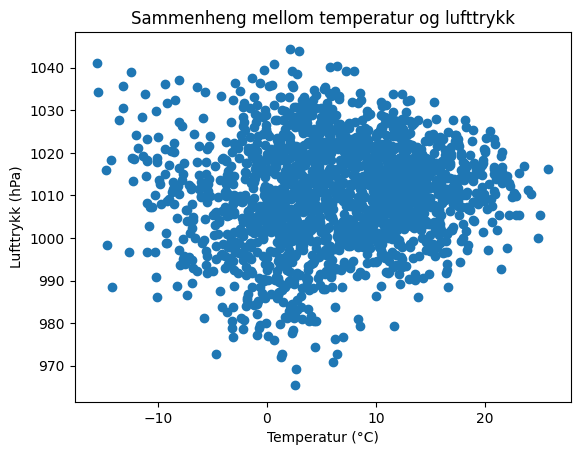

In [48]:
#Visualiserer sammenhengen mellom temperatur og trykk
plt.scatter(df["mean(air_temperature P1D)"], df["mean(air_pressure_at_sea_level P1D)"])
plt.xlabel("Temperatur (°C)")
plt.ylabel("Lufttrykk (hPa)")
plt.title("Sammenheng mellom temperatur og lufttrykk")
plt.show()

### Analyse og visualisering av varme, vindstille og tørre dager

                     Tidspunkt  mean(air_temperature P1D)  \
103  2020-06-21 00:00:00+00:00                       25.8   
110  2020-06-28 00:00:00+00:00                       25.1   
1571 2024-06-28 00:00:00+00:00                       24.9   
104  2020-06-22 00:00:00+00:00                       23.6   
839  2022-06-27 00:00:00+00:00                       23.1   
109  2020-06-27 00:00:00+00:00                       22.5   
843  2022-07-01 00:00:00+00:00                       22.3   
1611 2024-08-07 00:00:00+00:00                       22.2   
1196 2023-06-19 00:00:00+00:00                       22.0   
838  2022-06-26 00:00:00+00:00                       21.9   

      mean(wind_speed P1D)  sum(precipitation_amount P1D)  
103                    2.8                            0.0  
110                    2.5                            0.0  
1571                   2.3                            0.0  
104                    1.8                            0.0  
839                    1.5  

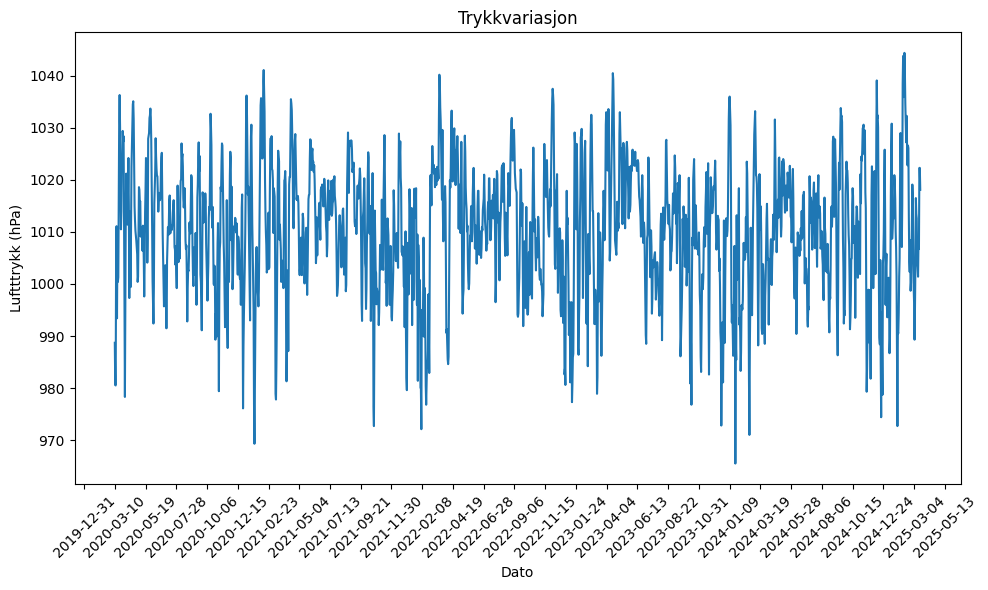

In [49]:
#Filtrerer på varme dager med lav vind og null nedbør

filtrert_df = df[(df["mean(air_temperature P1D)"] > 20) & 
            (df["mean(wind_speed P1D)"] < 5 ) &
            (df["sum(precipitation_amount P1D)"]== 0)]

#sorterer etter varmeste først og gir oss 10 øverste
filtrert_df = filtrert_df.sort_values("mean(air_temperature P1D)", ascending = False).head(10)
print(filtrert_df[["Tidspunkt", "mean(air_temperature P1D)", "mean(wind_speed P1D)", "sum(precipitation_amount P1D)"]])


#tegner dataen i plot

plt.figure(figsize= (10, 6))
plt.plot(df["Tidspunkt"], df["mean(air_pressure_at_sea_level P1D)"], label = "Lufttrykk")
plt.xlabel("Dato")
plt.ylabel("Luftttrykk (hPa)")
plt.title("Trykkvariasjon")
plt.xticks(rotation = 45)

#Viser bare en dato pr 10 dag, for å unngå rot

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval= 10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout() #alt skal få plass
plt.show()

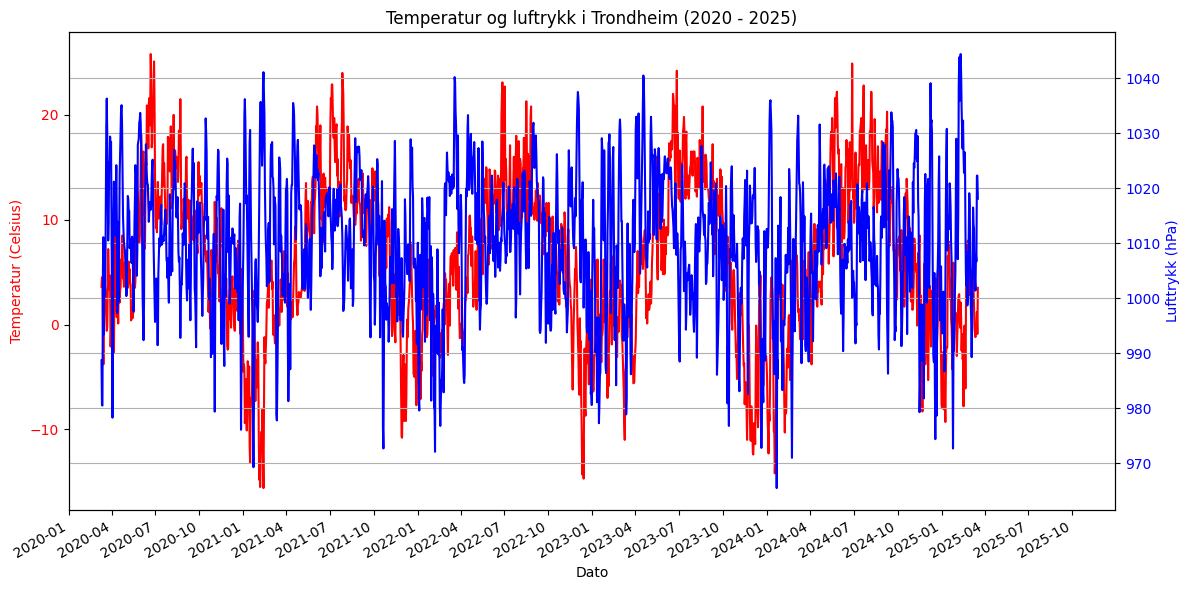

In [50]:
df["Tidspunkt"] = pd.to_datetime(df["Tidspunkt"])
fig, ax1 = plt.subplots(figsize= (12,6))


#aksetekst og farge
ax1.plot(df["Tidspunkt"], df["mean(air_temperature P1D)"], color = "red", label = "Temperatur")
ax1.set_xlabel("Dato")
ax1.set_ylabel("Temperatur (Celsius)", color = "red")
ax1.tick_params(axis= "y", labelcolor = "red")

#andre y_akse (trykk)
ax2 = ax1.twinx() #sekundær y akse
#plotter lufttrykk
ax2.plot(df["Tidspunkt"], df["mean(air_pressure_at_sea_level P1D)"], 
         color = "blue", label = "Lufttrykk (hPa)")
ax2.set_ylabel("Lufttrykk (hPa)", color = "blue")
ax2.tick_params(axis = "y", labelcolor = "blue")

#Tidsakse med kvartalsvis visning
#x aksen med ein dato kvær tredje måned, ÅÅÅÅ-MM
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.set_xlim(pd.to_datetime("2020-01-01"), pd.to_datetime("2025-12-31"))

#Tittel og layout
plt.title("Temperatur og luftrykk i Trondheim (2020 - 2025)")
fig.autofmt_xdate()
fig.tight_layout()
plt.grid(True)

plt.show()


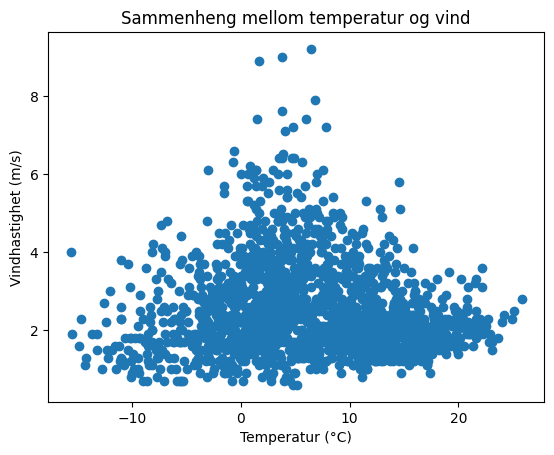

In [51]:
#scatterplot for temperatur vs vind
plt.scatter(df["mean(air_temperature P1D)"], df["mean(wind_speed P1D)"])
plt.xlabel("Temperatur (°C)")
plt.ylabel("Vindhastighet (m/s)")
plt.title("Sammenheng mellom temperatur og vind")
plt.show()

### Visualisering av værparametre over tid- fire separate tidsseriegrafer

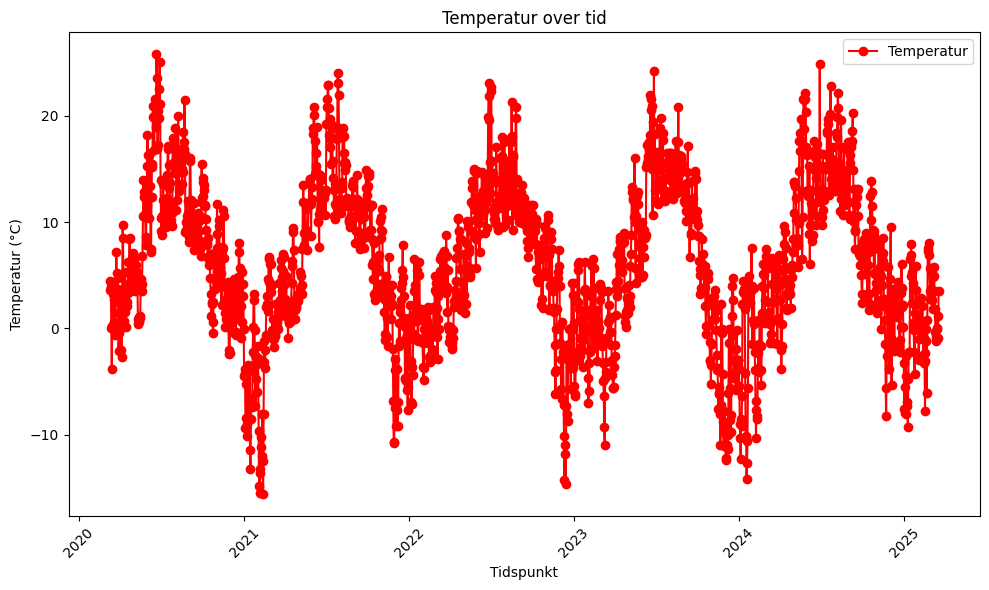

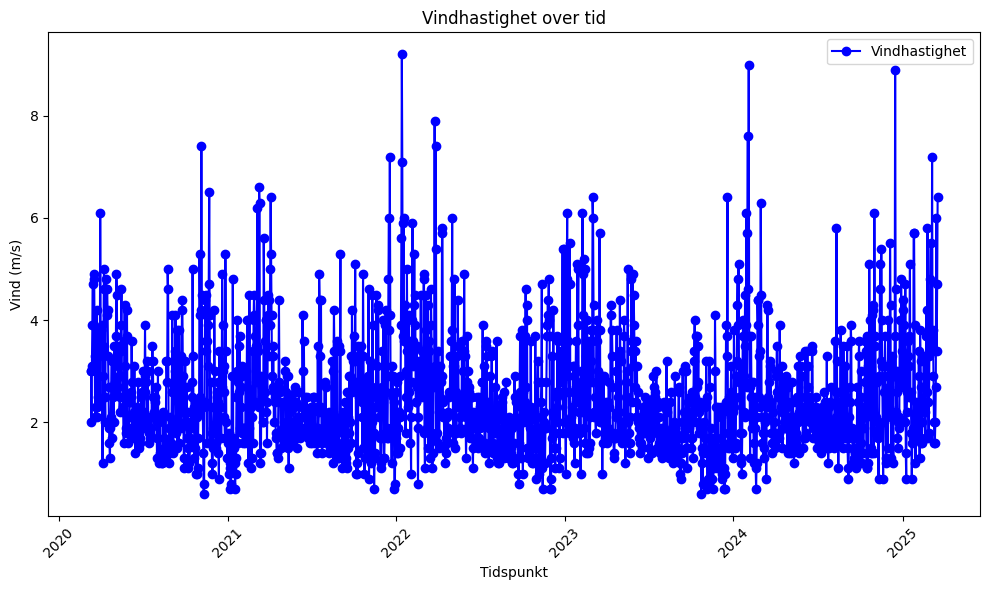

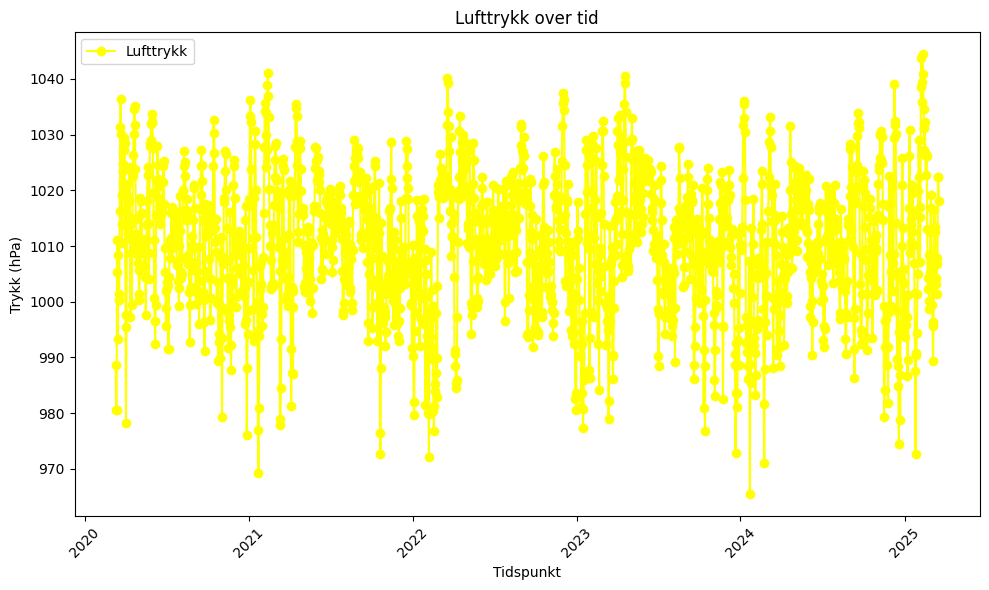

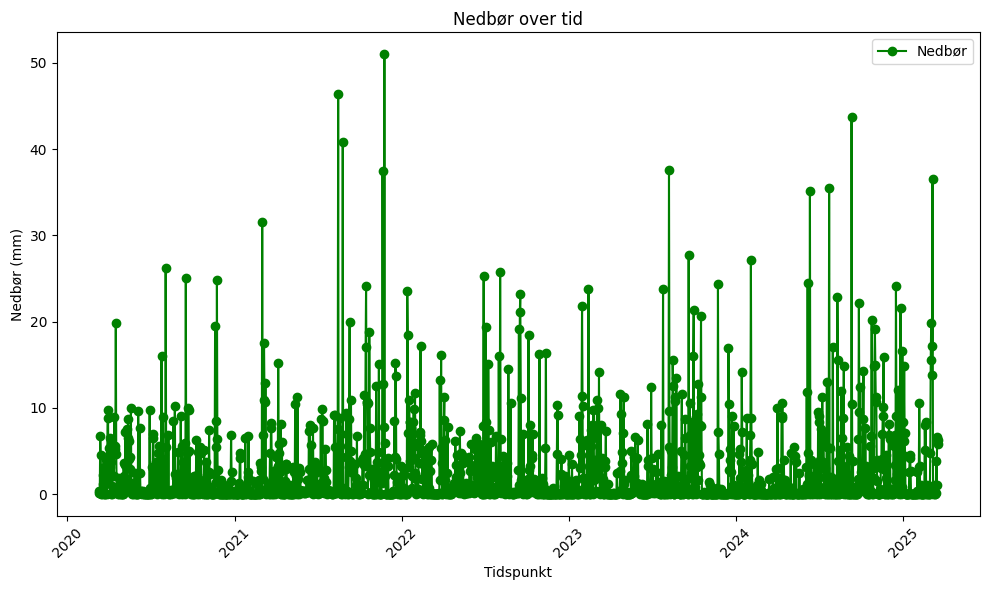

In [55]:
#temperaturplot
plt.figure(figsize = (10,6))
plt.plot(df['Tidspunkt'], df['mean(air_temperature P1D)'], color= 'red',marker = "o", linestyle = "-", label = "Temperatur")
plt.title("Temperatur over tid")
plt.xlabel("Tidspunkt")
plt.ylabel("Temperatur (°C)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Vindhastighetsplot
plt.figure(figsize=(10,6))
plt.plot(df['Tidspunkt'], df['mean(wind_speed P1D)'], color= 'blue',marker = "o", linestyle = "-", label = "Vindhastighet")
plt.title("Vindhastighet over tid")
plt.xlabel("Tidspunkt")
plt.ylabel("Vind (m/s)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Trykkplot
plt.figure(figsize=(10,6))
plt.plot(df['Tidspunkt'], df['mean(air_pressure_at_sea_level P1D)'], color= 'yellow',marker = "o", linestyle = "-", label = "Lufttrykk")
plt.title("Lufttrykk over tid")
plt.xlabel("Tidspunkt")
plt.ylabel("Trykk (hPa)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


#Nedbørplot
plt.figure(figsize=(10,6))
plt.plot(df['Tidspunkt'], df['sum(precipitation_amount P1D)'], color= 'green',marker = "o", linestyle = "-", label = "Nedbør")
plt.title("Nedbør over tid")
plt.xlabel("Tidspunkt")
plt.ylabel("Nedbør (mm)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


OPPGAVE 6- PREDIKTIV ANALYSE

### Maskinlæring: Forutsi neste dags temperatur med lineær regresjon


In [56]:

#Forbereder dataen
df["Temp_nextDay"] = df["mean(air_temperature P1D)"].shift(-1) 
df_model = df.dropna() #fjerner rader med manglende verdier, NaN

#Definerer X, det vi henter fra, og y som predikasjon
X = df_model[["mean(air_temperature P1D)", "mean(air_pressure_at_sea_level P1D)", "mean(wind_speed P1D)", "sum(precipitation_amount P1D)"]] 
y = df_model["Temp_nextDay"] 

#Splitter daten i ulike trening og test sett
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

#Trener opp  den lineære regresjonsmodellen
modell = LinearRegression() 
modell.fit(X_train, y_train) 
#bruker den trente modellen til å nå forutsi fremtidig data
y_pred = modell.predict(X_test) 
#evaluerer ytelsen til modellen
print("Mean Squared Error:", mean_squared_error(y_test, y_pred)) #Beregner gjennomsnitt av kvadrert feil mellom faktisk verdi og predikert verdi
print("R² Score:", r2_score(y_test, y_pred)) #Måler hvor mye av avriasjon i dataen modellen klarer å forklare. Jo nærmere 1 jo bedre


Mean Squared Error: 6.654188564950566
R² Score: 0.86777629487202


### Visualisering av faktisk og predikert temperatur

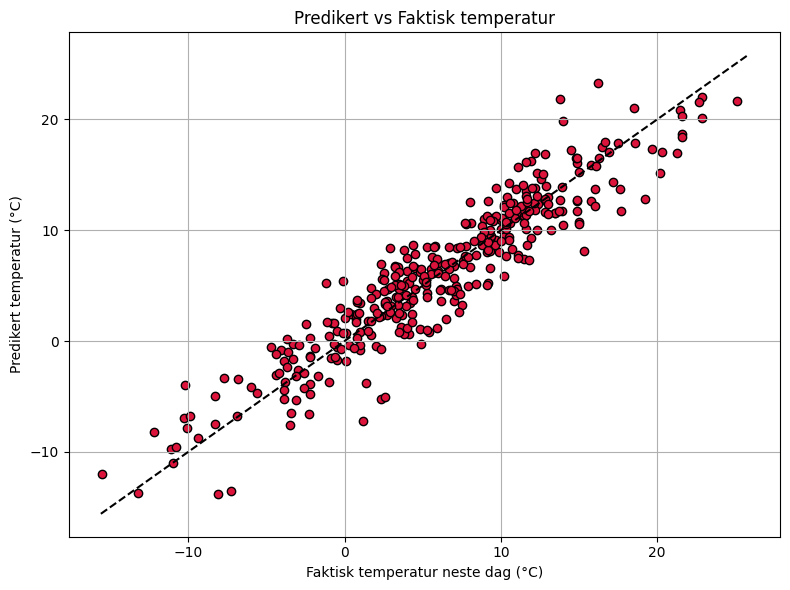

In [57]:
#Scatterplott som sammenligner predikert vs faktisk temperatur

plt.figure(figsize=(8,6)) #8*6 tommer, plotter stort
plt.scatter(y_test, y_pred, c='crimson', edgecolor='k') #y_test er på x_aksen, y_pred på y_aksen, C = crimson setter fargen på dottene, edgecolor gjør endekantene svarte

#Setter navn på aksene
plt.xlabel("Faktisk temperatur neste dag (°C)") 
plt.ylabel("Predikert temperatur (°C)") 

#Tittel på plottet
plt.title("Predikert vs Faktisk temperatur") 

#Tegner stiplet diagonal linje, predikert = faktisk. Alle punkter på linja er nøyaktige verdier
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--') 

#Rutenett i bakgrunnen, mer lesbart
plt.grid(True) 

#Alle etiketter og elementer vises ikke-avkuttet aksenavn
plt.tight_layout() 

#Viser plottet utskrevet
plt.show() 

### Linjediagram: Faktisk temperatur vs forutsagt temperatur neste dag

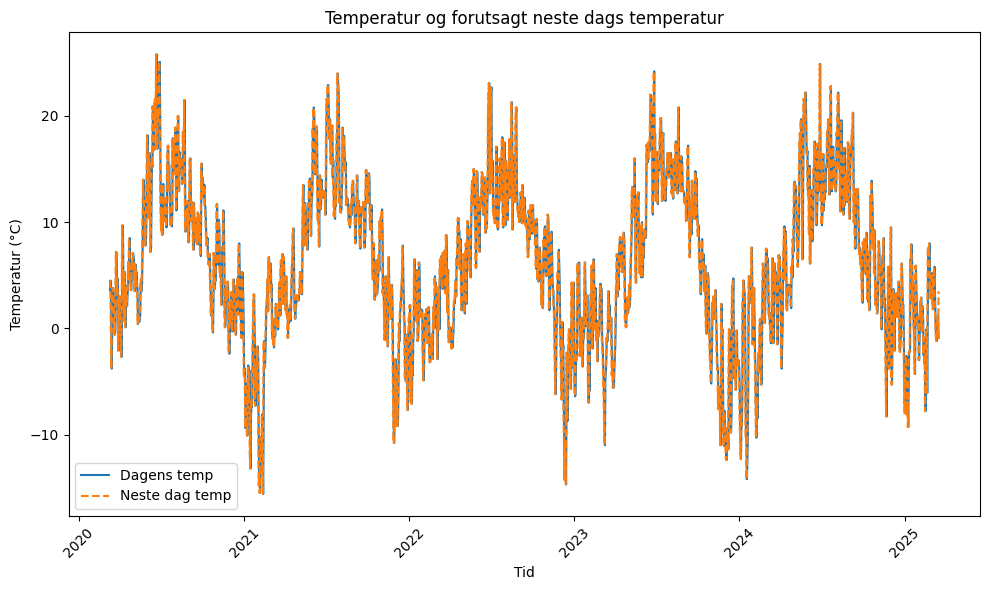

In [58]:
#Lager linjediagram som viser faktisk temperatur, og predikert temperatur for neste dag over tid

plt.figure(figsize=(10,6)) #10*6 tommer, plotter stort
plt.plot(df_model["Tidspunkt"], df_model["mean(air_temperature P1D)"], label="Dagens temp") #Plotter dagens temp, tidspunkt i forhold til dagens gj.snittstemp
plt.plot(df_model["Tidspunkt"], df_model["Temp_nextDay"], label="Neste dag temp", linestyle='--') #Plotter predikert temperatur for neste dag, med samme tidspunkt. inneholder modellens predikasjon D+1, linjene gjøres stiplet

#Setter navn på aksene
plt.xlabel("Tid") 
plt.ylabel("Temperatur (°C)") 

#Tittel på plottet
plt.title("Temperatur og forutsagt neste dags temperatur") 

#Datoene på x_aksen 45 grader rotert for mer lesbart
plt.xticks(rotation=45) 

#Forklaring for linja
plt.legend() 

#Sikrer ingen overlapp
plt.tight_layout() 

#Printer plottet
plt.show() 

### Histogram: Fordeling av feil mellom faktisk og predikert temperatur

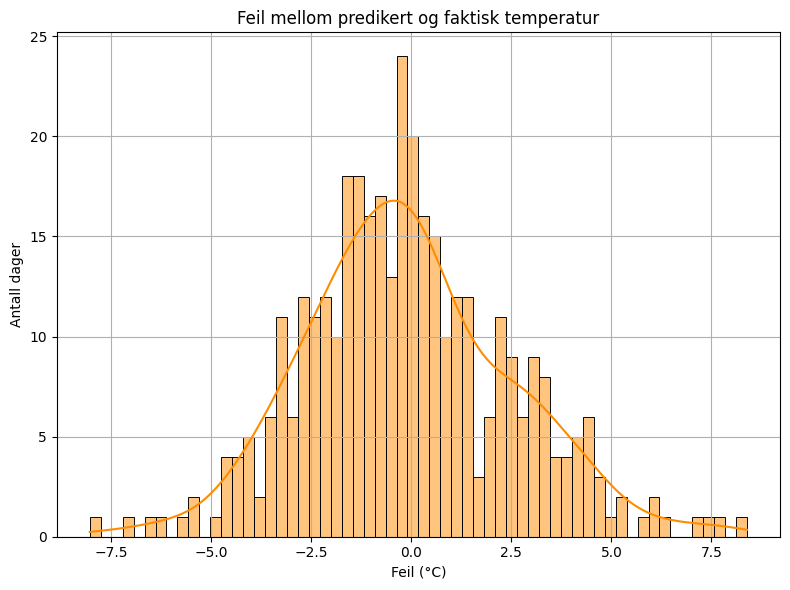

In [59]:
#Histogram som viser fordeling av feil/residualer mellom predikert og faktisk temperatur

#Faktisk verdi minus predikert verdi (feilen), avviket er målt i grader celsius
residuals = y_test - y_pred 

#Lager stort og lesbart histogram
plt.figure(figsize=(8,6)) 

#Lager histogram seaborn med sns, som viser verdi av fordelingene. Bins deler verdienene i 60 grupper, altså 5*12 måneder, kde sørger for en glatt kurve
sns.histplot(residuals, bins=60, kde=True, color="darkorange") 

#Tittel på plottet
plt.title("Feil mellom predikert og faktisk temperatur") 

#Tittel på aksene
plt.xlabel("Feil (°C)") 
plt.ylabel("Antall dager") 

#Legger til rutenett
plt.grid(True) 

#Ingen overlapping 
plt.tight_layout() 

plt.show() 

### Helhetlig klimaanalyse + temperaturpredikasjon for Trondheim 2026

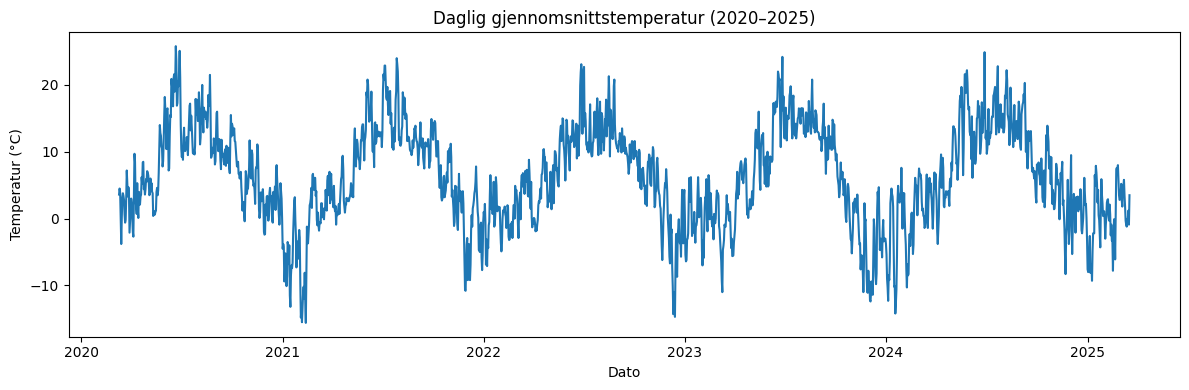

C:\Users\eriks\AppData\Local\Temp\ipykernel_25912\366757833.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_precip = df.resample('M', on='Tidspunkt').sum(numeric_only=True)


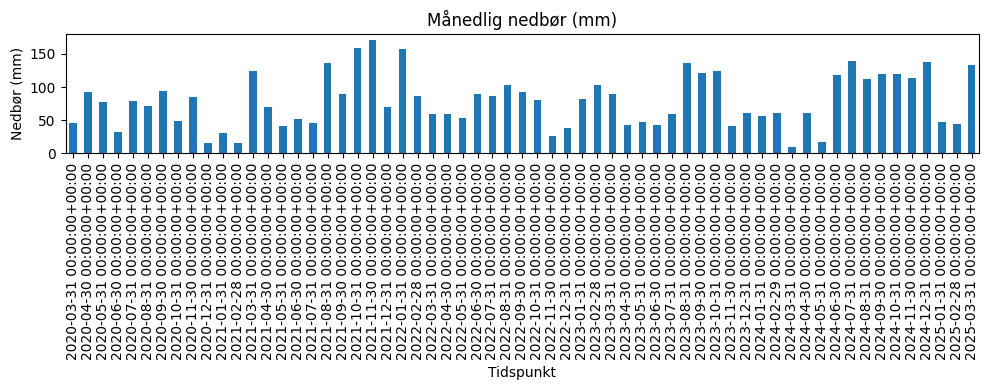

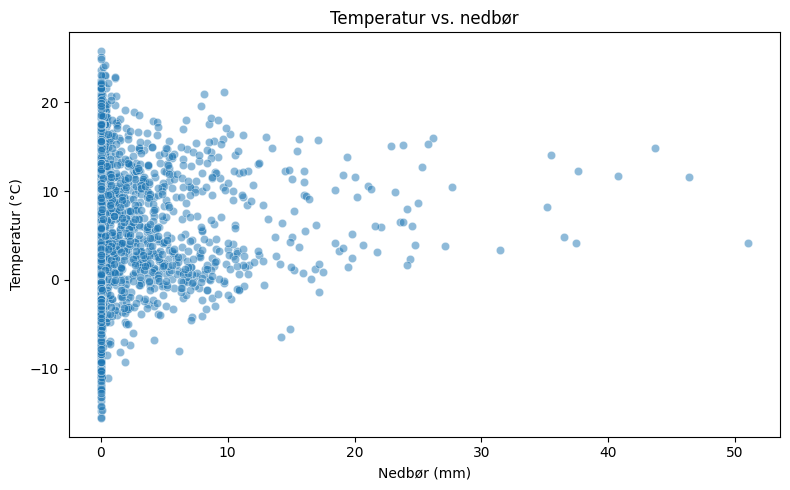

NameError: name 'mean_absolute_error' is not defined

In [62]:
#Leser inn værdata fra CSV-fil og tolker 'Tidspunkt' som en datatime-kolonne
df = pd.read_csv("trondheim_vaerdata_full.csv", parse_dates = ['Tidspunkt'])

#Ekstraherer året og dagen i året fra datoen
df['year'] = df['Tidspunkt'].dt.year 
df['day_of_year'] = df['Tidspunkt'].dt.dayofyear 


#Håndterer manlende verdier
#Interpolerer manglende temperaturverdier (Legger inn nærliggende verdier)
df['mean(air_temperature P1D)'] = df['mean(air_temperature P1D)'].interpolate() 

#Fjerner rader hvor temperaturen fortsatt er NaN etter interpolasjon
df = df.dropna(subset=['mean(air_temperature P1D)']) 

 

#Visualiserer Temperatur over tid
plt.figure(figsize=(12, 4)) 
sns.lineplot(data=df, x='Tidspunkt', y='mean(air_temperature P1D)') 
plt.title("Daglig gjennomsnittstemperatur (2020–2025)") 
plt.xlabel("Dato") 
plt.ylabel("Temperatur (°C)") 
plt.tight_layout() 
plt.show() 

 

#Visualiserer månedlig nedbør i søylediagram
monthly_precip = df.resample('M', on='Tidspunkt').sum(numeric_only=True) 
plt.figure(figsize=(10, 4)) 
monthly_precip['sum(precipitation_amount P1D)'].plot(kind='bar') 
plt.title("Månedlig nedbør (mm)") 
plt.ylabel("Nedbør (mm)") 
plt.tight_layout() 
plt.show() 

 

#Visualiserer Temperatur vs Nedbør i scatterplot
plt.figure(figsize=(8, 5)) 
sns.scatterplot(data=df, x='sum(precipitation_amount P1D)', y='mean(air_temperature P1D)', alpha=0.5) 
plt.title("Temperatur vs. nedbør") 
plt.xlabel("Nedbør (mm)") 
plt.ylabel("Temperatur (°C)") 
plt.tight_layout() 
plt.show() 

 
#Modelltrening
#Velger forklaringsvariabler (features) og målet (target)
features = df[['year', 'day_of_year']] 
target = df['mean(air_temperature P1D)'] 

 

#Deler opp datasettet
#Trener modellen på data fra 2025
#Tester modellen på temperaturene for 2025
X_train = features[df['year'] < 2025] 
X_test = features[df['year'] == 2025] 
y_train = target[df['year'] < 2025] 
y_test = target[df['year'] == 2025] 

 #Initialiserer og trener en lineær regresjonsmodell
model = LinearRegression() 
model.fit(X_train, y_train) 

#Evaluerer modellen på testdata (2025)
y_pred = model.predict(X_test) 

#Beregmer feil mål
print("MAE:", mean_absolute_error(y_test, y_pred)) 
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred))) 

 
#Predikasjon for 2026
future_2026 = pd.DataFrame({ 
    'year': [2026] * 366, 
    'day_of_year': list(range(1, 367))  # 2026 er skuddår 
}) 
#Bruker modellen til å forutsi temperaturene for 2026
future_2026['predicted_temperature'] = model.predict(future_2026) 

#Visualisering av prediksjonen 
plt.figure(figsize=(10, 4)) 
plt.plot(future_2026['day_of_year'], future_2026['predicted_temperature']) 
plt.title("Forventet daglig temperatur i 2026 (lineær regresjon)") 
plt.xlabel("Dag i året") 
plt.ylabel("Predikert temperatur (°C)") 
plt.tight_layout() 
plt.show()

### Predikasjon av daglig temperatur for 2026- dag for dag - modellering

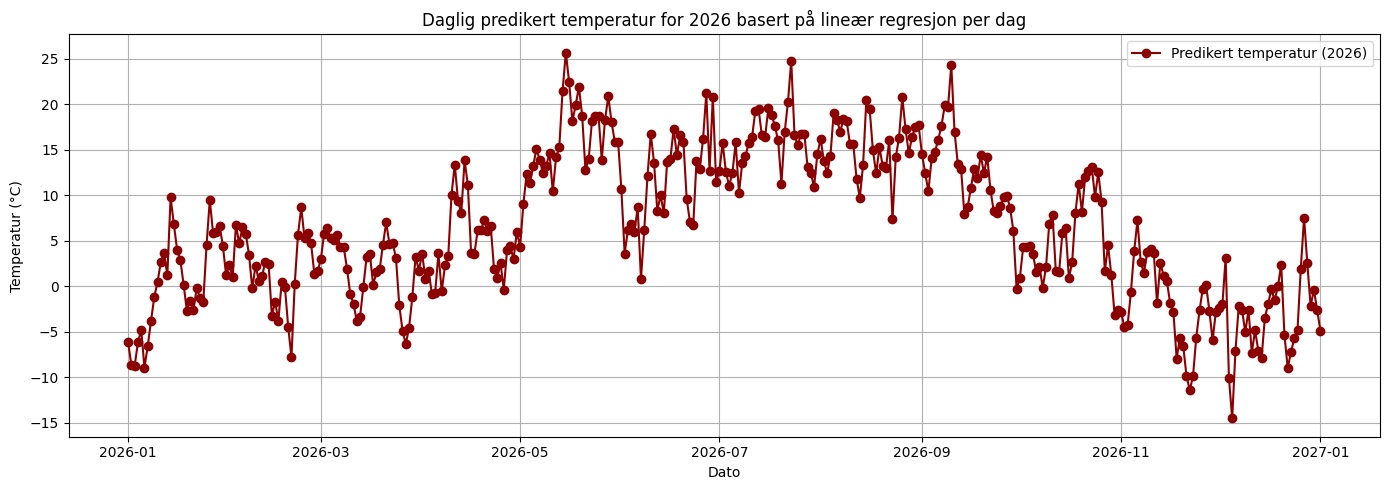

In [63]:
 
#Laster inn værdata fra CSV-filen og tolker Tidspunkt som dato/tid
df = pd.read_csv("trondheim_vaerdata_full.csv", parse_dates=['Tidspunkt']) 


#Ekstraherer år og dag i året fra tidskolonnen
df['year'] = df['Tidspunkt'].dt.year #Henter ut årstall
df['day_of_year'] = df['Tidspunkt'].dt.dayofyear #Henter ut hvilkendag i året det er


#Håndterer manglende temperaturverdier ved interpolasjon
df['mean(air_temperature P1D)'] = df['mean(air_temperature P1D)'].interpolate() 
#Fjerner rader der temperaturen er NaN 
df = df.dropna(subset=['mean(air_temperature P1D)']) 


#Trener modellen per dag i året
#Lager en liste for å lagre predikerte temperaturverdier for 2026
predicted_2026 = [] 

for day in range(1, 367):  #1 til 366 (inkl. skuddårsdager)
    #Filtrerer ut data for kun denne dagen i året for alle årene
    df_day = df[df['day_of_year'] == day] 

     
    #Trenger minst to år med data for å hente verdier
    #sjekker at vi har dette
    if df_day['year'].nunique() < 2: 
        continue 

    #Setter opp inndata X og målvariabel y    
    X = df_day[['year']]  #bruker år som forklaringsvariabel
    y = df_day['mean(air_temperature P1D)'] #Temperatur som avhengig variabel

    #Initialiserer og trener lineær regresjonsmodell
    model = LinearRegression() 
    model.fit(X, y) 


    #Predikerer temperatur for året 2026
    temp_2026 = model.predict(pd.DataFrame({'year':[2026]}))[0] 
    predicted_2026.append((day, temp_2026)) 

 
#Lager DataFrame med predikasjonene
df_pred_2026 = pd.DataFrame(predicted_2026, columns=['day_of_year', 'predicted_temperature']) 
#Konverterer 'day_of_year' til faktiske datoer i 2026
df_pred_2026['date'] = pd.to_datetime('2026-01-01') + pd.to_timedelta(df_pred_2026['day_of_year'] - 1, unit='D') 

 
#Visualiserer predikasjonen for 2026
plt.figure(figsize=(14, 5)) 
plt.plot(df_pred_2026['date'], df_pred_2026['predicted_temperature'], 'o-', color='darkred', label='Predikert temperatur (2026)') 
plt.title("Daglig predikert temperatur for 2026 basert på lineær regresjon per dag") 
plt.xlabel("Dato") 
plt.ylabel("Temperatur (°C)") 
plt.grid(True) 
plt.legend() 
plt.tight_layout()
 
#Viser plottet
plt.show() 

### Predikasjon av daglig vind og nedbør for 2026- dag for dag- modellering

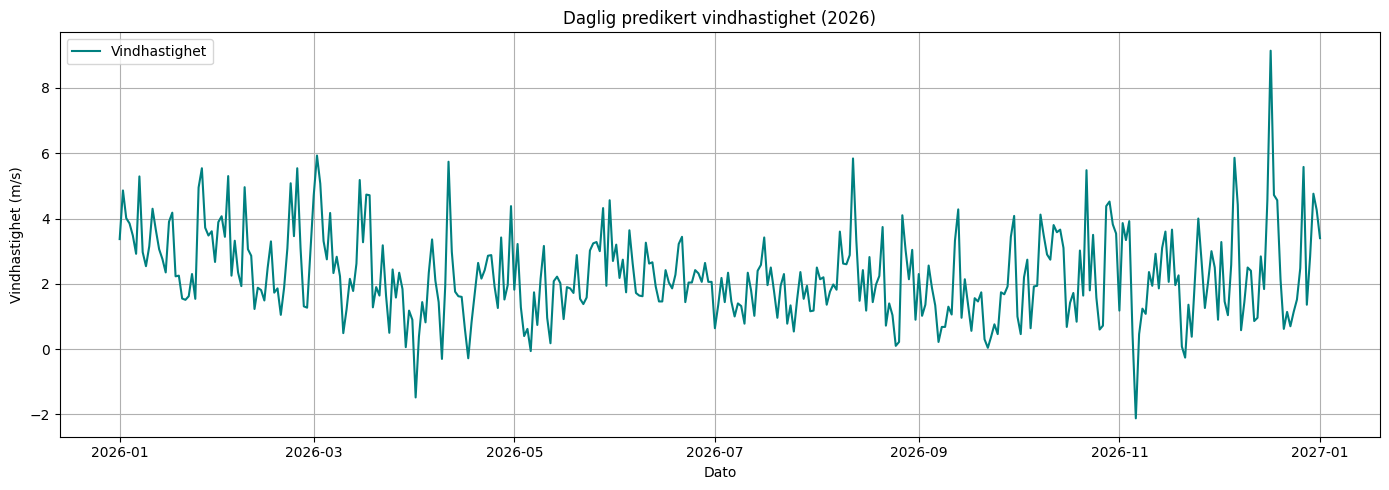

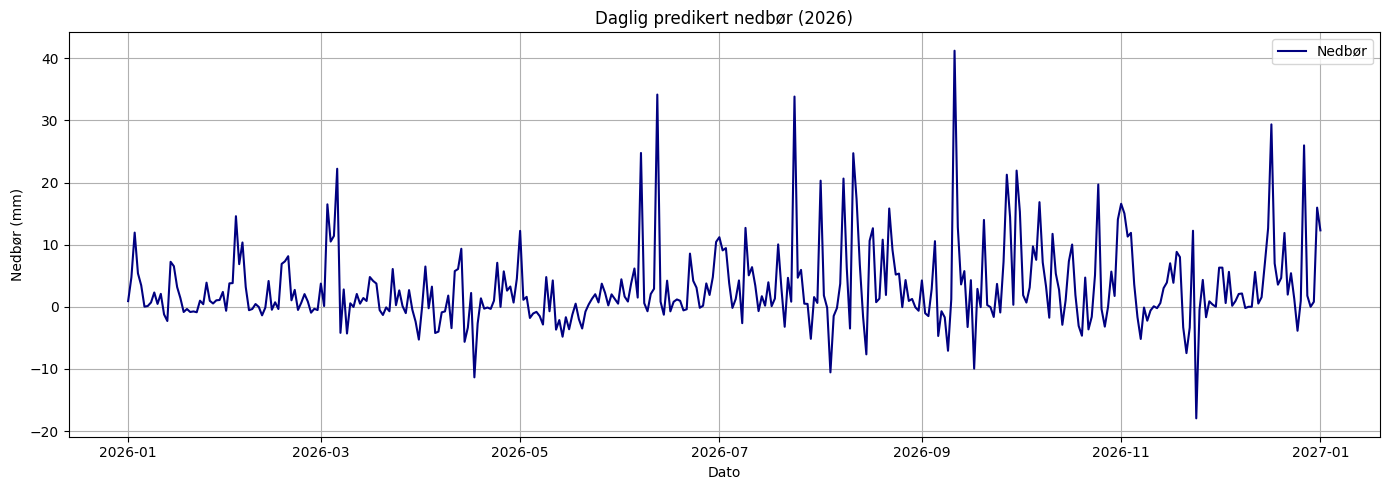

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression 

#leser inn data fra CSV
df = pd.read_csv("trondheim_vaerdata_full.csv", parse_dates=['Tidspunkt']) 

 

#Ekstraher år og dag i året , kolonner for år og dag
df['year'] = df['Tidspunkt'].dt.year 
df['day_of_year'] = df['Tidspunkt'].dt.dayofyear 

 
#Interpolerer og fjerner rader med manglende verdier 
df['mean(wind_speed P1D)'] = df['mean(wind_speed P1D)'].interpolate() 
df['sum(precipitation_amount P1D)'] = df['sum(precipitation_amount P1D)'].interpolate() 

df = df.dropna(subset=['mean(wind_speed P1D)', 'sum(precipitation_amount P1D)']) 

 
#Funskjon for å predikere en variabel
def prediker_per_dag(df, variabel, label): 
    prediksjoner = [] 
    for day in range(1, 367): #gjennom kvær dag i året
        df_day = df[df['day_of_year'] == day] 

        if df_day['year'].nunique() < 2: #filterer ut dager vi ikkje har data for 2 år
            continue 

        X = df_day[['year']] #åårstall
        y = df_day[variabel] #målevariabel

        model = LinearRegression() 
        model.fit(X, y) #trener modell
        pred_2026 = model.predict(pd.DataFrame({'year': [2026]}))[0] #forutseier for 2026
        prediksjoner.append((day, pred_2026)) #lagrer dag og predikasjon

    df_pred = pd.DataFrame(prediksjoner, columns=['day_of_year', label]) 
    df_pred['date'] = pd.to_datetime('2026-01-01') + pd.to_timedelta(df_pred['day_of_year'] - 1, unit='D') 
    return df_pred 

 

#Lager predikasjoner
df_wind_2026 = prediker_per_dag(df, 'mean(wind_speed P1D)', 'Predikert vind (m/s)') 
df_precip_2026 = prediker_per_dag(df, 'sum(precipitation_amount P1D)', 'Predikert nedbør (mm)') 

#Visualiserer vindhastighet
plt.figure(figsize=(14, 5)) 
plt.plot(df_wind_2026['date'], df_wind_2026['Predikert vind (m/s)'], label='Vindhastighet', color='teal') 
plt.title("Daglig predikert vindhastighet (2026)") 
plt.xlabel("Dato") 
plt.ylabel("Vindhastighet (m/s)") 
plt.grid(True) 
plt.tight_layout() 
plt.legend() 
plt.show() 

 
#Visualiserer nedbør
plt.figure(figsize=(14, 5)) 
plt.plot(df_precip_2026['date'], df_precip_2026['Predikert nedbør (mm)'], label='Nedbør', color='navy') 
plt.title("Daglig predikert nedbør (2026)") 
plt.xlabel("Dato") 
plt.ylabel("Nedbør (mm)") 
plt.grid(True) 
plt.tight_layout() 
plt.legend() 
plt.show() 
